# Forecasting realized volatility in the SPY ETF with a simple Heterogenous AutoregRessive of Realized Volatility (HAR-RV) model
## Nathan Simonis
The goal of this notebook is to fit a simple HAR-RV model to forecast realized volatility in SPY.  This model assumes that investors with different time horizons percieve volatility differently [Muller et al.(1993)](https://ssrn.com/abstract=5370). 

Therefore, we will try to forecast the realized volatility in one day by taking into account the RV of the previous day, the previous week, the previous month, the closing price of an implied volatility index (VIX) and the daily traded volume in SPY.

The main papers followed to implement the simple HAR-RV are:
- Haugom, Erik and Langeland, Henrik and Molnár, Peter and Westgaard, Sjur, Forecasting Volatility of the U.S. Oil Market (January 29, 2014). Available at SSRN: https://ssrn.com/abstract=2691391
- Corsi, Fulvio, A Simple Long Memory Model of Realized Volatility (August 18, 2004). Available at SSRN: https://ssrn.com/abstract=626064 

In [1]:
# Required packages
import pandas as pd
import numpy as np 
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller as adf
from statsmodels.graphics.gofplots import qqplot
from pandas.plotting import register_matplotlib_converters
from pandas.plotting import autocorrelation_plot
from pandas_datareader import data
from scipy import stats

In [2]:
%matplotlib inline
register_matplotlib_converters()
warnings.filterwarnings('ignore')

In [3]:
ticker = "SPY"

We import our intraday 1 minute data of SPY that ranges from ***2007-04-24*** to ***2020-01-31***.

In [4]:
# Import & clean intraday data
df = pd.read_csv(f"{ticker}1min_clean.csv")

df.rename(columns = {"Unnamed: 0":"Date"}, inplace = True)
df.index = pd.to_datetime(df["Date"])
df.drop(["Date", "Inc Vol"], axis = 1, inplace = True)

df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-31 15:56:00,321.960,322.12,321.800,321.8012,90230832
2020-01-31 15:57:00,321.800,321.94,321.630,321.8700,91551615
2020-01-31 15:58:00,321.870,322.09,321.865,322.0500,92175746
2020-01-31 15:59:00,322.045,322.15,321.860,322.1300,93086934
2020-01-31 16:00:00,322.125,322.18,321.720,321.7400,95730412


We resample the 1 minute data to a 5 minute timeframe as [Andersen et al (2000)](https://ssrn.com/abstract=267791) argue this sampling interval is optimal for a liquid market.

In [5]:
# Resample 1min to 5min
sample = '5T'
df = df.resample(sample).agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum'})
df.dropna(inplace = True)

df.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2020-01-31 15:40:00,321.140,321.69,320.73,321.53,396442013
2020-01-31 15:45:00,321.530,321.96,321.28,321.72,418134057
2020-01-31 15:50:00,321.720,322.08,321.35,322.08,435617404
2020-01-31 15:55:00,322.070,322.15,321.63,322.13,456274810
2020-01-31 16:00:00,322.125,322.18,321.72,321.74,95730412


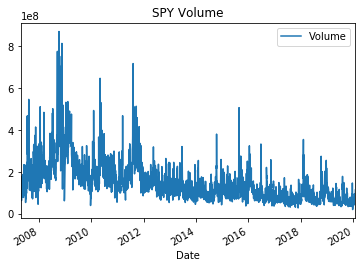

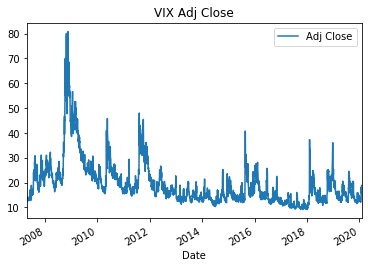

In [6]:
# Download VIX & SPY volume data from yahoo finance
start = str(df.index[0].date())
end = str(df.index[-1].date())

SPY_daily = data.DataReader("SPY", start=start, end=end, data_source="yahoo")[["Volume"]]# Import only the columns we need
VIX_daily = data.DataReader("^VIX", start=start, end=end, data_source="yahoo")[["Adj Close"]]

SPY_daily.plot(title = "SPY Volume");plt.show()
VIX_daily.plot(title = "VIX Adj Close");plt.show()

Now that we have the data, there are 4 major steps to follow:
- Compute daily realized volatilty from intraday data.
- Average the values over 5 periods to get rolling weekly realized volatility and 22 periods for monthly realized volatility.
- Estimate the HAR-RV coefficients.
- Measure the performance of the model.

We start by computing the daily RV, based on $n$ intraday prices:
$RV^d_t =  \sqrt {\sum_{j=0}^{n-1} r^2_{t-j\Delta}}$

Where:
- $r_{t-j\Delta} = \Delta \left(p_{t-j} - p_{t-(j+1)}\right)$
- $\Delta = 1d/n_{periods}$
- $p_t$ is the price at time $t$
- $n$ is the number of 5 minute bars in a trading day

In [7]:
# Compute number of periods/day
df["D"] = df.index.date
n_periods = df.pivot_table(index = ["D"], aggfunc = 'size').values

stats.describe(n_periods)

DescribeResult(nobs=3216, minmax=(46, 79), mean=78.94807213930348, variance=0.7447365621348931, skewness=-25.01310872726569, kurtosis=777.3181192560647)

We then compute $r^2_{t-j\Delta}$ for all days.  

In [8]:
df.loc[df["D"] != df["D"].shift(), "Per"]  = n_periods
df.fillna(method = 'ffill', inplace = True)

df["Ret"] = np.where(df["D"] == df["D"].shift(),
                    ( (df["Close"]-df["Close"].shift()) * 1/df["Per"] ) **2, np.nan)

In [9]:
# Perform the sum grouped by days.
rv = df.groupby("D")["Ret"].agg(np.sum).to_frame()

In [10]:
# Add sqrt to get Realized-Vol
rv.columns = ["RV_daily"]
rv["RV_daily"] = np.sqrt(rv["RV_daily"])

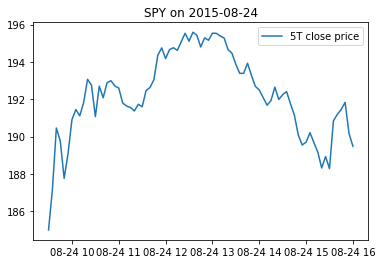

In [11]:
# Check what day in the dataset had the highest realized vol
date = str(rv["RV_daily"].idxmax())
plt.plot(df["Close"].loc[date], label = f"{sample} close price")
plt.title(f"{ticker} on {date}")
plt.legend()
plt.show()

We can compute the weekly and monthly RV with:
- Weekly : $RV^w_t = \frac{1}{5} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1w}\right)$
- Monthly : $RV^m_t = \frac{1}{21} \left(RV^d_{t-1d} + RV^d_{t-2d} + \dots + RV^d_{t-1m}\right)$

In [12]:
# Compute weekly and monthly RV.  
rv["RV_weekly"] = rv["RV_daily"].rolling(5).mean()
rv["RV_monthly"] = rv["RV_daily"].rolling(21).mean()
rv.dropna(inplace = True)

In [13]:
#Add IV & Volume variables
rv["VIX"] = VIX_daily.loc[rv.index]
rv["SPY_volume"] = SPY_daily.loc[rv.index]

print(rv.head()); print(rv.describe())

            RV_daily  RV_weekly  RV_monthly    VIX   SPY_volume
D                                                              
2007-05-22  0.008048   0.008035    0.008496  13.06   82148800.0
2007-05-23  0.010378   0.008232    0.008564  13.24  133786600.0
2007-05-24  0.016139   0.009741    0.008945  14.08  187593000.0
2007-05-25  0.008617   0.010121    0.009010  13.34   83309200.0
2007-05-29  0.009269   0.010490    0.009068  13.53   82020000.0
          RV_daily    RV_weekly   RV_monthly          VIX    SPY_volume
count  3196.000000  3196.000000  3196.000000  3196.000000  3.196000e+03
mean      0.015007     0.014993     0.014968    19.423589  1.528849e+08
std       0.009089     0.008011     0.007003     9.189397  1.012582e+08
min       0.003235     0.003674     0.005963     9.140000  2.027000e+07
25%       0.009278     0.009899     0.010282    13.527500  8.198735e+07
50%       0.012531     0.012731     0.012840    16.705000  1.254304e+08
75%       0.017438     0.017033     0.017678    

In [14]:
# Check for stationarity with adf test
print("p-value for daily RV:", adf(rv["RV_daily"].values)[1])
print("p-value for weekly RV:",adf(rv["RV_weekly"].values)[1])
print("p-value for monthly RV:",adf(rv["RV_monthly"].values)[1])
print("p-value for VIX Adj Close:",adf(rv["VIX"].values)[1])
print("p-value for SPY Volume:",adf(rv["SPY_volume"].values)[1])

p-value for daily RV: 2.6527630912380016e-08
p-value for weekly RV: 2.2463393539243536e-05
p-value for monthly RV: 4.364629700908245e-06
p-value for VIX Adj Close: 0.0030788218776327306
p-value for SPY Volume: 0.006436055593370449


For all timeframes, the p-value is $\le 0.01$ thus, we reject the null hypothesis that the time series has a unit root.  The time series is stationary.

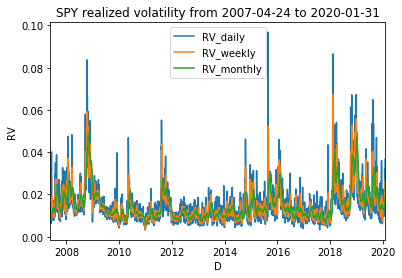

In [15]:
# Plot the RV variables.  
rv[["RV_daily","RV_weekly","RV_monthly"]].plot(title = f"{ticker} realized volatility from {df.index.date[0]} to {df.index.date[-1]}")
plt.ylabel("RV")
plt.show()

As the volume, RVs and VIX price have significantly different ranges, we perform min-max normalization:

$X_{scaled} = \frac{X - min(X)}{max(X)-min(X)}$

In [16]:
# Prepare data 
rv["Target"] = rv["RV_daily"].shift(-1) #We want to predict the RV of the next day.  
rv.dropna(inplace = True)

#Scale the data
rv_scaled = (rv-rv.min())/(rv.max()-rv.min())

#Add constant c
rv_scaled = sm.add_constant(rv_scaled)

#Split train and test sets
split = int(0.60 * rv.shape[0])
X = rv_scaled.drop("Target", axis = 1)
y = rv_scaled[["Target"]]
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

We can now train the parameters for HAR. $\hat{RV_{t+1d}^{d}} = \hat{\beta_0} + \hat{\beta_1} RV_t^d + \hat{\beta_2} RV_t^w + \hat{\beta_3} RV_t^m + \hat{\beta_4}IV_t + \hat{\beta_5}VOL_t $ 

We do this with OLS:
$\hat{\beta} = (X'X)^{-1}X'Y$

In [17]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       0.684
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     828.5
Date:                Sat, 20 Jun 2020   Prob (F-statistic):               0.00
Time:                        20:46:21   Log-Likelihood:                 3142.7
No. Observations:                1917   AIC:                            -6273.
Df Residuals:                    1911   BIC:                            -6240.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111      0.002      5.227      0.000       0.007       0.015
RV_daily       0.4266      0.033     12.915      0.000       0.362       0.491
RV_weekly      0.2109      0.027      7.786      0.000       0.158       0.264
RV_monthly     0.0253      0.018      1.388      0.165      -0.010       0.061
VIX            0.0564      0.017      3.284      0.001       0.023       0.090
SPY_volume     0.0248      0.020      1.232      0.218      -0.015       0.064
==============================================================================
Omnibus:                      874.072   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13500.766
Skew:                           1.736   Prob(JB):                         0.00
Kurtosis:                      15.529   Cond. No.                         39.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For $\hat{\beta_3}$ (***RV_monthly***) and $\hat{\beta_5}$ (***SPY_volume***), we do not reject the null hypothesis.  Thus, these variables are not statistically significant when making a next day forecast.

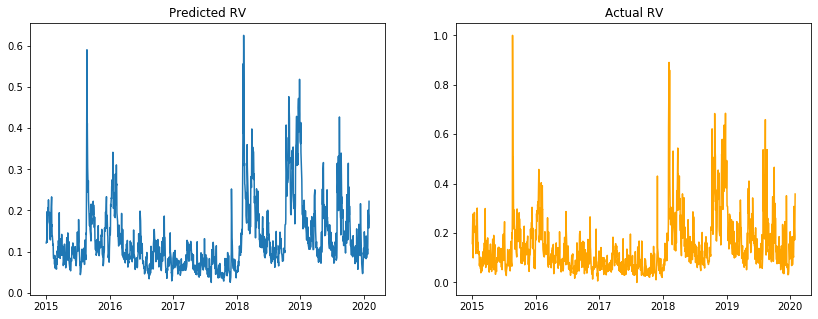

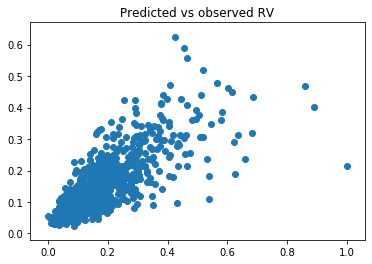

In [18]:
# Perform out of sample prediction
y_hat = results.predict(X_test)

plt.figure(figsize = (14,5))

#Predicted RV
plt.subplot(1,2,1)
plt.plot(y_test.index, y_hat)
plt.title("Predicted RV")

#Actual RV
plt.subplot(1,2,2)
plt.plot(y_test.index, y_test, color = "orange")
plt.title("Actual RV")
plt.show()

plt.scatter(y_test, y_hat)
plt.title("Predicted vs observed RV")
plt.show()

In [19]:
# Metrics
def score(y_hat, y, metric):
    """Return metrics of y_hat vs. y

    Args:
        y_hat (np.array): Predicted values
        y (np.array): Actual values
        metric (str): Metric to use

    Returns:
        float: The metric
    """
    if metric == "MSE": 
        return np.mean( (y_hat-y)**2)
    elif metric == "R_squared":
        ss_res = np.sum( (y - y_hat)**2 )
        ss_tot = np.sum( (y - np.average(y)) **2)
        return 1 - ss_res/ss_tot
    elif metric == "MAE":
        return np.mean( np.abs(y-y_hat))

In [20]:
#In-sample scores
print("In-sample scores")

y_hat_is = results.predict(X_train)
mse_is = score(y_hat_is, y_train.values.ravel(), "MSE")
r_sq_is = score(y_hat_is, y_train.values.ravel(), "R_squared")
mae_is = score(y_hat_is, y_train.values.ravel(), "MAE")

print(f"MSE:{mse_is}, R^2:{r_sq_is}, MAE:{mae_is}")      

print("----------------")
               
#Out-of-sample scores
print("Out-of-sample scores")
               
mse_oos = score(y_hat, y_test.values.ravel(), "MSE")
r_sq_oos = score(y_hat, y_test.values.ravel(), "R_squared")
mae_oos = score(y_hat, y_test.values.ravel(), "MAE")

print(f"MSE:{mse_oos}, R^2:{r_sq_oos}, MAE:{mae_oos}")

In-sample scores
MSE:0.002205852299603129, R^2:0.6843082416657069, MAE:0.030870900180617243
----------------
Out-of-sample scores
MSE:0.005025543560782526, R^2:0.5961413812082574, MAE:0.04371104686850498


The explanatory variables explain $59.6\%$ of the variance of the dependent variable out-of-sample.

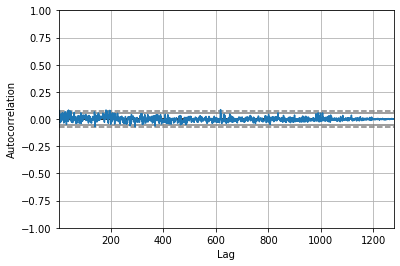

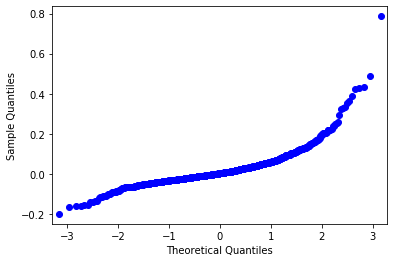

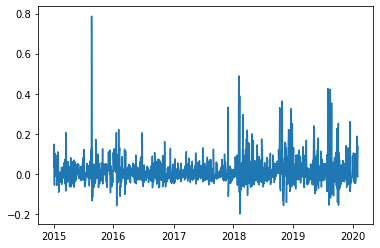

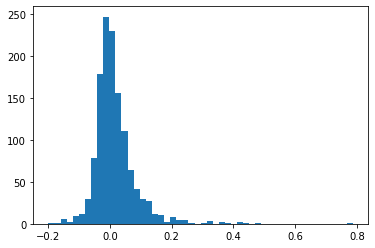

In [21]:
# Residuals
residuals = y_test.values.ravel() - y_hat

autocorrelation_plot(residuals);plt.show()
qqplot(residuals);plt.show()
plt.plot(residuals);plt.show()
plt.hist(residuals, bins = 50); plt.show()

The residuals appear to look like white noise.